# Définition des descripteurs pour le mapping des paramètres de contrôle de l'instrument virtuel

**Fonctions utiles :**
```
from descripteurs import Classifier_son, Classifier_regimes, Classifier_justesse
```

### Liste des descripteurs : 

**Un son est produit**

Le descripteur est le moyennage des amplitudes sur la fin des oscillations (source : Missoum, Vergez & Doc, 2014) :

$$
\begin{equation}
D_{son} = \frac{1}{N_{2/3}} \sum_{N_{2/3}} p(t_i)
\end{equation}
\tag{1}
$$

Classification :
- D_{son} > $\epsilon_1$ : oscillations 
- D_{son} $\leq$ $\epsilon_1$ : régime statique

-> $\epsilon_1$ à déterminer

**Régime d'oscillation**

Distinction entre régime périodique et régime quasi-périodique. Pour cela on utilise la forme de l'enveloppe de puissance de la pression au niveau de l'embouchure. 

$$
\begin{equation}
D_{régime} = \frac{Var(power)}{<power>}
\end{equation}
\tag{2}
$$

Dans le cours de Christophe, $\epsilon_2 = 10^{-2}$

**Justesse de la note**

La justesse est évaluée en cents (réf : Missoum, Vergez & Doc, 2014). 
$$
\begin{equation}
D_{note} = 1200 \log_2\left( \frac{f_{act}}{f_{ref}} \right)
\tag{3}
\end{equation}
$$
Le seuil pour la classification $\epsilon_3$ est fixé à 5 cents d'écart entre la fréquence de référence et la fréquence produite calculée à partir de l'algorithme de Yin dans l'article. Ici, on remplace cet algorithme temporel par la méthode du produit spectral (fait l'hypothèse qu'il existe de l'énergie dans le spectre en $f_0$, plus robuste que la somme spectrale.)

**Longueur du transitoire d'attaque**

idées de ressource :
- thèse victor Salvador-castrillo (violon), 2024
- evangelista, acquilino, 2025
- Peeters et al., The Timbre Toolbox ..., 2010
- Rodet, Jaillet : Detection and modeling of fast attack transients

**Bifurcation directe ou indirecte à l'extinction et au seuil d'oscillation**

Taillard et Kergomard, 2013

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from time import time
from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.ticker as mticker
#from clarinette_classe import Clarinette_DelayLine

91.53617358207703
Temps d'exécution (s) : 88.10147094726562


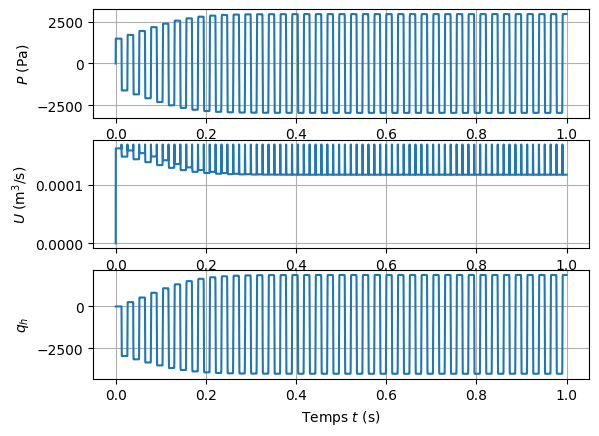

In [ ]:
# Test de clarinette_classe + signal test

L = 0.58               # longueur du résonateur (m)
T_deg = 20             # température (°C)
w = 1.3*10**(-2)       # largeur du canal d'anche (m)
H = 10**(-3)           # ouverture d'anche au repos (m)
P_M = 10*10**3         # pression de plaquage (Pa)
gamma = 0.38           # pression dans la bouche adimensionnée --> entre 1/3 et 1/2
zeta = 0.4            # paramètre d'ouverture d'anche adimensionné --> entre 0.2 et 0.6
T_sec = 1         # durée simulée (s)
fs = 44100*2

clarinette = Clarinette_DelayLine(L = L, temperature = T_deg, w =  w, H = H, P_M = P_M)
clarinette.params_controle_musicien(gamma,zeta)
clarinette.affiche_result(T_sec, fs)


Temps d'exécution (s) : 2.0796759128570557


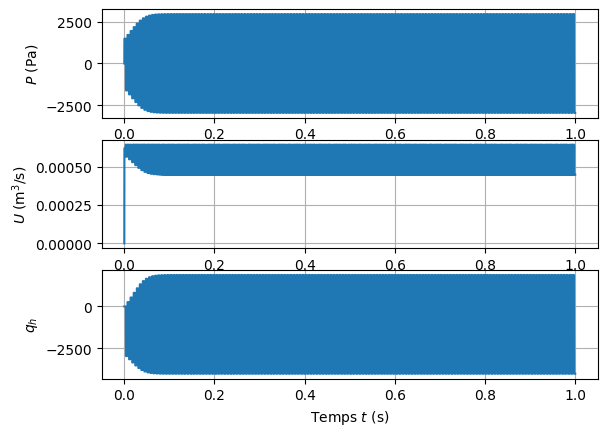

C:\Users\Lalie\AppData\Local\Temp\ipykernel_3764\3869825532.py:265: RuntimeWarning: divide by zero encountered in divide
  Z_e2 = Zc * (1+R_e2) / (1-R_e2)
C:\Users\Lalie\AppData\Local\Temp\ipykernel_3764\3869825532.py:265: RuntimeWarning: invalid value encountered in divide
  Z_e2 = Zc * (1+R_e2) / (1-R_e2)


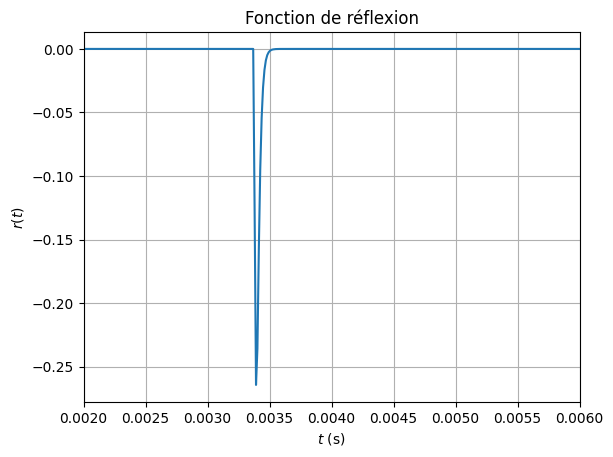

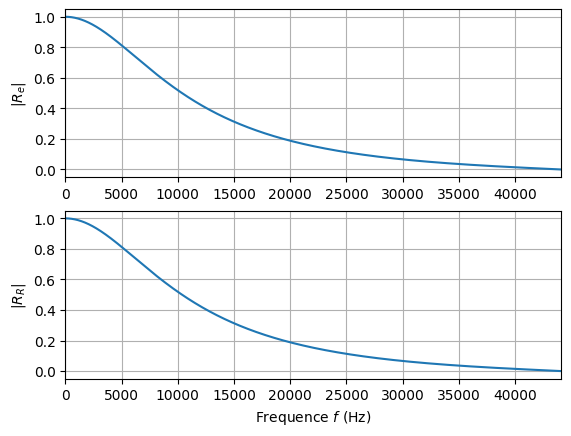

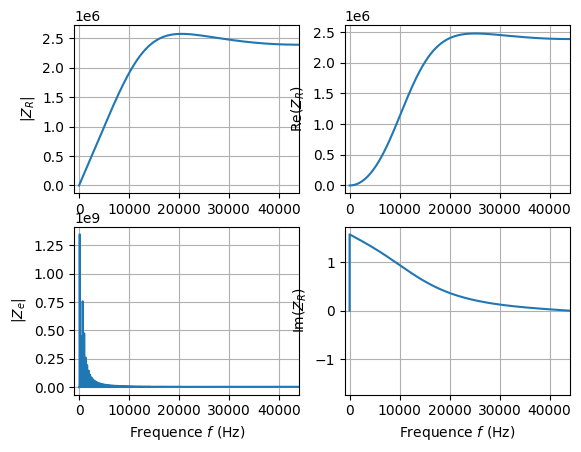

In [7]:
# Clarinette de Coline : 

# PARAMETRES PHYSIQUES ET VARIABLES

T_sec = 1         # durée simulée (s)

# Paramètres physiques

T_deg = 20             # température (°C)
T_K = 273.15 + T_deg   # température (K)
c = 20.05*np.sqrt(T_K) # vitesse du son (m/s)
rho = 1.292*273.15/T_K # masse volumique de l'air (kg/m^3)
lv = 4e-8
lt = 5.6e-8
cp_over_cv = 1.402

# Paramètres d'anche et de résonateur

gamma = 0.38           # pression dans la bouche adimensionnée --> entre 1/3 et 1/2
zeta = 0.4            # paramètre d'ouverture d'anche adimensionné --> entre 0.2 et 0.6

H = 10**(-3)           # ouverture d'anche au repos (m)
w = 1.3*10**(-2)       # largeur du canal d'anche (m)
P_M = 10*10**3         # pression de plaquage (Pa)
Ks = P_M / H           # raideur anche (Pa/m)
P_m = gamma * P_M      # pression dans la bouche (Pa)
U_A = w*H*np.sqrt(2/rho*P_M)
Zc = zeta*P_M/U_A      # impédance caractéristique (kg/s)
S = rho*c/Zc           # section du résonateur (m^2)
R = np.sqrt(S/np.pi)   # rayon du résonateur (m)
L = 0.58               # longueur du résonateur (m)
alpha = 2/(R*c**(3/2)) * ( np.sqrt(lv) + (cp_over_cv-1)*np.sqrt(lt))

# Paramètres utiles pour la simulation

T = 2*L/c               # temps de parcours d'un aller-retour (s)
#delta_t = T/128         # pas de temps (s)
#fs = int(np.rint(1/delta_t)) # fréquence d'échantillonage
fs = 44100*2
delta_t = 1/fs

# FONCTIONS

# Caractéristique non-linéaire
@njit
def F(P, gamma=gamma, zeta=zeta, P_M=P_M, Zc=Zc):
    """
    Caractéristique non-linéaire F telle que u = F(P_m-p)

    Parameters
    ----------
        P : float, pression dans le bec (Pa)
        gamma : float, pression dans la bouche adimensionnée
        zeta : float, paramètre d'ouverture d'anche adimensionné
        P_M : float, pression de plaquage
        Zc : float, impédance caractéristique
    Returns
    -------
        U : float, débit volumique dans le bec
    """
    p = P/P_M # pression adimensionnée
    if np.abs(gamma-p) <= 1:
        u = zeta * (1+p-gamma) * np.sqrt(np.abs(gamma-p)) * (gamma-p)/np.abs(gamma-p) # débit adimensionné
    else :
        u = 0
    U = u*P_M/Zc # débit dimensionné
    return U

@njit
def func_dicho(P, params):
    """
    Fonction dont on veut trouver le zéro par dichotomie
    
    Parameters
    ----------
        P : float, valeur de la pression dans le bec à laquelle on évalue la fonction
        params : array
    """
    qh, Zc = params[0], params[1]
    return F(P) - 1/Zc*(P-qh)

@njit
def dichotomie(func, params, a, b, n, tol=1e-9):
    """ 
    Trouver l'abcisse m tel que func(m) = 0 par dichotomie
    
    Parameters
    ----------
        func : fonction, fonction dont on cherche l'annulation
        params : array, paramètres d'entrée de la fonction
        a : float, borne minimale de l'intervalle de recherche
        b : float, borne maximale de l'intervalle de recherche
        tol : float, tolérance de précision sur la valeur de l'abcisse obtenue
        
    Returns
    -------
        m : float, abcisse pour laquelle la fonction s'annule
    """
    
    if func(a,params)*func(b,params) > 0:
        print("Mauvais choix des bornes de l'intervalle, n=",n)
    else :
        m = (a+b)/2
        
        while np.abs(a-b) > tol:
            if func(m,params) == 0.:
                return m
            elif func(a,params)*func(m,params) > 0:
                a = m
            else :
                b = m
            m = (a+b)/2
            
        return m
    

# BOUCLE TEMPORELLE

D = int(np.rint(2*L/c * fs))
beta = 2*R/(c/fs)
n1 = 0.167
d1 = 1.393
d2 = 0.457

@njit
def execution(T_sec, delta_t,  gamma, zeta, P_M, Zc):

    temps = np.arange(0, T_sec, delta_t)
    N = len(temps)
    
    # Initialisation
    U, P, P_ext, qh = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
    # Boucle
    for n in range(1,N):
    
        # calcul de qh à l'instant
        if n >= 2 :
            qh_prev2 = qh[n-2]
        else : 
            qh_prev2 = 0
        
        if n >= D :
            q0_D = P[n-D] + Zc*U[n-D]
        else :
            q0_D = 0
            
        if n >= D+1 :
            q0_D1 = P[n-D-1] + Zc*U[n-D-1]
        else :
            q0_D1 = 0
        
        if n >= D+2:
            q0_D2 = P[n-D-2] + Zc*U[n-D-2]
        else :
            q0_D2 = 0
            
        qh[n] = -2*(1-d2*beta**2)*qh[n-1] - (1 - d1*beta + d2*beta**2)*qh_prev2 \
            - (1+n1*beta)*q0_D - 2*q0_D1 - (1-n1*beta)*q0_D2
        qh[n] /= (1 + d1*beta + d2*beta**2)
        
        # calcul de q et f à l'instant t
        # trouver l'intersection entre la courbe F(P) et la droite U = 1/Zc*(P-qh) par dichotomie
        P[n] = dichotomie(func_dicho, [qh[n],Zc], -P_M, P_M, n)
        U[n] = F(P[n])
        P_ext[n] = (P[n]+U[n] - (P[n-1]+U[n-1])) / delta_t
        
    return temps, U, P, P_ext, qh
     

start = time()
temps, U, P, P_ext, qh = execution(T_sec, delta_t, gamma, zeta, P_M, Zc)
stop = time()
print("Temps d'exécution (s) :", stop-start)
    
# AFFICHAGE

plt.figure()
plt.subplot(311)
plt.plot(temps,P)
plt.ylabel(r"$P$ (Pa)")
plt.grid()

plt.subplot(312)
plt.plot(temps,U)
plt.ylabel(r"$U$ (m$^3$/s)")
plt.grid()

plt.subplot(313)
plt.plot(temps,qh)
plt.xlabel(r"Temps $t$ (s)")
plt.ylabel(r"$q_h$")
plt.grid()
plt.show()

#%%

# TRACE FONCTION DE REFLEXION

T_sec = 1
fs = 44100*2
temps = np.arange(0, T_sec, 1/fs)
N = len(temps)

D = int(np.rint(2*L/c * fs))
beta = 2*R/(c/fs)
n1 = 0.167
d1 = 1.393
d2 = 0.457

q0 = np.zeros(N)
q0[0] = 1 # impulsion
qi = np.zeros(N)

for n in range(1,N):

    # calcul de qh à l'instant
    if n >= 2 :
        qi_prev2 = qi[n-2]
    else : 
        qi_prev2 = 0
    
    if n >= D :
        q0_D = q0[n-D]
    else :
        q0_D = 0
        
    if n >= D+1 :
        q0_D1 = q0[n-D-1]
    else :
        q0_D1 = 0
    
    if n >= D+2:
        q0_D2 = q0[n-D-2]
    else :
        q0_D2 = 0
        
    qi[n] = -2*(1-d2*beta**2)*qi[n-1] - (1 - d1*beta + d2*beta**2)*qi_prev2 \
        - (1+n1*beta)*q0_D - 2*q0_D1 - (1-n1*beta)*q0_D2
    qi[n] /= (1 + d1*beta + d2*beta**2)
    # print(qi[n])

# # fonction de réflexion théorique (pertes mais pas de rayonnement) --Chaigne
# r_th = np.zeros(N)
# x = 2*L
# B = 1.044/R * np.sqrt(2*lv/c)
# D2 = B*x/2
# r_th[D+1:] = D2/np.sqrt(np.pi) * np.exp(-D2**2/(temps[D+1:]-x/c))/(temps[D+1:]-x/c)**(3/2) * np.exp(-1.080*x*lv/R**2)
# r_th /= np.max(np.abs(r_th))

freq = np.linspace(0,fs, fs)
k = 2*np.pi*freq/c
z = np.exp(2j*np.pi*freq/fs)

R_e = np.fft.fft(qi,fs)
R_r = R_e * z**D
Z_r = Zc * (1+R_r) / (1-R_r)
Z_e = Zc * (1+R_e) / (1-R_e)

R_r3 = (1 + n1*1j*k*R) / (1 + d1*1j*k*R + d2*(1j*k*R)**2)
R_r2 = ((1+n1*beta)+2*z**(-1)+(1-n1*beta)*z**(-2))/((1+d1*beta+d2*beta**2)+2*(1-d2*beta**2)*z**(-1)+(1-d1*beta+d2*beta**2)*z**(-2))
R_e2 = R_r2 * z**(-D)
Z_r2 = Zc * (1+R_r2) / (1-R_r2+1e-14)
Z_r3 = Zc * (1+R_r3) / (1-R_r3+1e-14)
Z_e2 = Zc * (1+R_e2) / (1-R_e2)
r2 = np.fft.ifft(R_r2,fs)

plt.figure()
plt.plot(temps,qi)
plt.xlabel("$t$ (s)")
plt.ylabel("$r(t)$")
plt.title("Fonction de réflexion")
plt.xlim(0.002,0.006)
plt.grid()

plt.figure()
plt.subplot(211)
plt.plot(freq,np.abs(R_e))
#plt.plot(freq,np.abs(R_e2),'--')
plt.ylabel(r"$|R_e|$")
plt.xlim(0,fs/2)
plt.grid()
plt.subplot(212)
plt.plot(freq,np.abs(R_r))
#plt.plot(freq,np.abs(R_r2),'--')
#plt.plot(freq,np.abs(R_r3),'--')
plt.ylabel(r"$|R_R|$")
plt.xlabel(r"Frequence $f$ (Hz)")
plt.xlim(0,fs/2)
plt.grid()

plt.figure()
plt.subplot(221)
plt.plot(freq, np.abs(Z_r))
#plt.plot(freq, np.abs(Z_r2),'--')
#plt.plot(freq, np.abs(Z_r3),'--')
plt.ylabel(r"$|Z_R|$")
plt.xlim(-1000,fs/2)
plt.grid()
plt.subplot(223)
plt.plot(freq, np.abs(Z_e))
#plt.plot(freq, np.abs(Z_e2),'--')
plt.ylabel(r"$|Z_e|$")
plt.xlabel(r"Frequence $f$ (Hz)")
plt.xlim(-1000,fs/2)
plt.grid()
plt.subplot(222)
plt.plot(freq,Z_r.real)
#plt.plot(freq, np.real(Z_r2),'--')
plt.ylabel(r"Re($Z_R$)")
plt.xlim(-1000,fs/2)
plt.grid()
plt.subplot(224)
plt.plot(freq,np.angle(Z_r))
#plt.plot(freq, np.angle(Z_r2),'--')
plt.ylabel(r"Im($Z_R$)")
plt.xlabel(r"Frequence $f$ (Hz)")
plt.xlim(-1000,fs/2)
plt.grid()

In [8]:
class LatinSquare : 

    def __init__(self, n_data, u, dims = 2):
        from scipy.stats import qmc
        self.n_data = n_data
        self.u = u
        self.dims = dims
        self.sampler = qmc.LatinHypercube(self.dims)

    def indices(self) : 
        """
        Renvoie une liste d'indices suivant une distribution en carré latin
        """
        return self.sampler.integers(self.u, n=self.n_data)

In [21]:
gamma = np.linspace(0,1,1000)
zeta = np.linspace(0,1,1000)

n_data = 500
carre_latin = LatinSquare(n_data, u = len(gamma))
indexes = carre_latin.indices()

def simulation(T_sec, delta_t, gamma, zeta, P_M, Zc, ret_time=False): #Remise en forme pour pouvoir cartographier ensuite
    start = time()
    _, _, P, _, _ = execution(T_sec, delta_t, gamma, zeta, P_M, Zc)
    stop = time()
    if ret_time:
        return P, stop-start
    else:
        return P

## 1. Régime oscillant atteint

In [11]:
def descripteur_son(P) : 
    N = len(P)
    N_tiers = N % 3
    P_tiers = P[2*N_tiers:]
    return np.mean(P_tiers)

def classifieur_son(D_son, eps1) : 
    c = 0 # classe du son, 0 si régime statique ou 1 si régime oscillant
    if D_son > eps1 : 
        c = 1 
    return c

In [23]:
D_son = np.zeros(len(indexes))

for i, index in enumerate(indexes): 
    print("epoch :", i + 1, "/", n_data)
    P = simulation(T_sec, delta_t, gamma[index[0]],zeta[index[1]],P_M,Zc)
    D_son[i] = descripteur_son(P)

epoch : 1 / 500
epoch : 2 / 500
epoch : 3 / 500
epoch : 4 / 500
epoch : 5 / 500
epoch : 6 / 500
epoch : 7 / 500
epoch : 8 / 500
epoch : 9 / 500
epoch : 10 / 500
epoch : 11 / 500
epoch : 12 / 500
epoch : 13 / 500
epoch : 14 / 500
epoch : 15 / 500
epoch : 16 / 500
epoch : 17 / 500
epoch : 18 / 500
epoch : 19 / 500
epoch : 20 / 500
epoch : 21 / 500
epoch : 22 / 500
epoch : 23 / 500
epoch : 24 / 500
epoch : 25 / 500
epoch : 26 / 500
epoch : 27 / 500
epoch : 28 / 500
epoch : 29 / 500
epoch : 30 / 500
epoch : 31 / 500
epoch : 32 / 500
epoch : 33 / 500
epoch : 34 / 500
epoch : 35 / 500
epoch : 36 / 500
epoch : 37 / 500
epoch : 38 / 500
epoch : 39 / 500
epoch : 40 / 500
epoch : 41 / 500
epoch : 42 / 500
epoch : 43 / 500
epoch : 44 / 500
epoch : 45 / 500
epoch : 46 / 500
epoch : 47 / 500
epoch : 48 / 500
epoch : 49 / 500
epoch : 50 / 500
epoch : 51 / 500
epoch : 52 / 500
epoch : 53 / 500
epoch : 54 / 500
epoch : 55 / 500
epoch : 56 / 500
epoch : 57 / 500
epoch : 58 / 500
epoch : 59 / 500
epoch 

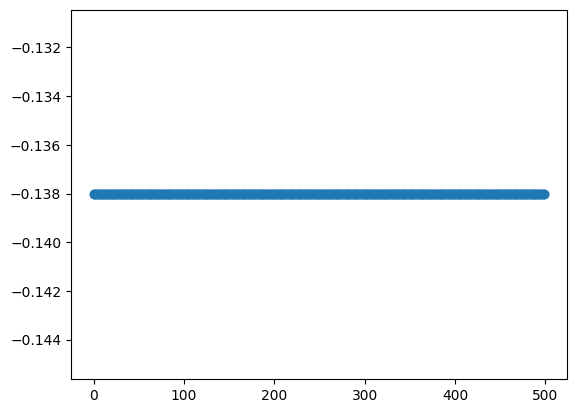

In [24]:
plt.scatter(np.arange(len(D_son)), D_son)

C:\Users\Lalie\AppData\Local\Temp\ipykernel_3764\3404927899.py:8: RuntimeWarning: invalid value encountered in log10
  ax.scatter(gamma[indexes[:,0]], zeta[indexes[:,0]], np.log10(D_son))


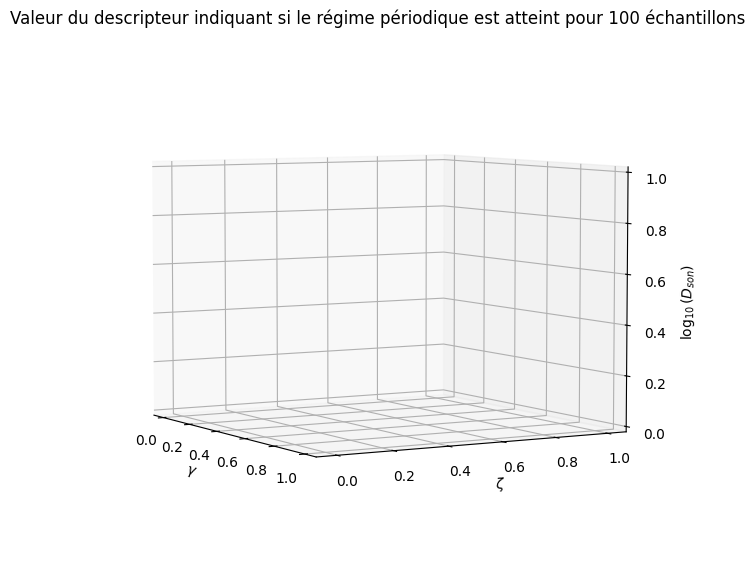

In [17]:
eps1 = 50
axis = np.linspace(0,1,500)
yi, xi = np.meshgrid(axis,axis)
zi = np.full_like(xi, np.log10(eps1))

fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gamma[indexes[:,0]], zeta[indexes[:,0]], np.log10(D_son))
#ax.plot_surface(xi,yi,zi,alpha = 0.4, label = "seuil eps1")
ax.set_zlabel(r"$\log_{10}(D_{son})$")
ax.set_ylabel(r"$\zeta$")
ax.set_xlabel(r"$\gamma$")
ax.set_title("Valeur du descripteur indiquant si le régime périodique est atteint pour 100 échantillons")
#ax.legend()
ax.view_init(elev=5., azim=-30, roll=0)

Par lecture graphique, on obtient $\epsilon_1 \approx 50$ USI.

In [57]:
class Classifier_son:
    
    def __init__(self, eps1 = 50):
        self.eps1 = eps1
    
    def descripteur_son(self, P) :
        """
        Renvoie la valeur de la pression moyennée sur le dernier tiers des échantillons
        """ 
        N = len(P)
        N_tiers = N % 3
        P_tiers = P[2*N_tiers:]
        return np.mean(P_tiers)
    
    def classifieur_son(self, P) :
        """
        Renvoie 0 si les paramètres ne permettent pas de produire un son, 1 sinon.  
        """
        D_son = self.descripteur_son(P)
        c = 0
        if D_son > self.eps1 : 
            c = 1 
        return c

**Question : est-ce qu'on obtient le même $\epsilon_1$ pour le violon ? 

## 2. Régime d'oscillation

0.011997699737548828 0.08739256858825684 0.0460658073425293


Text(0, 0.5, 'pwr')

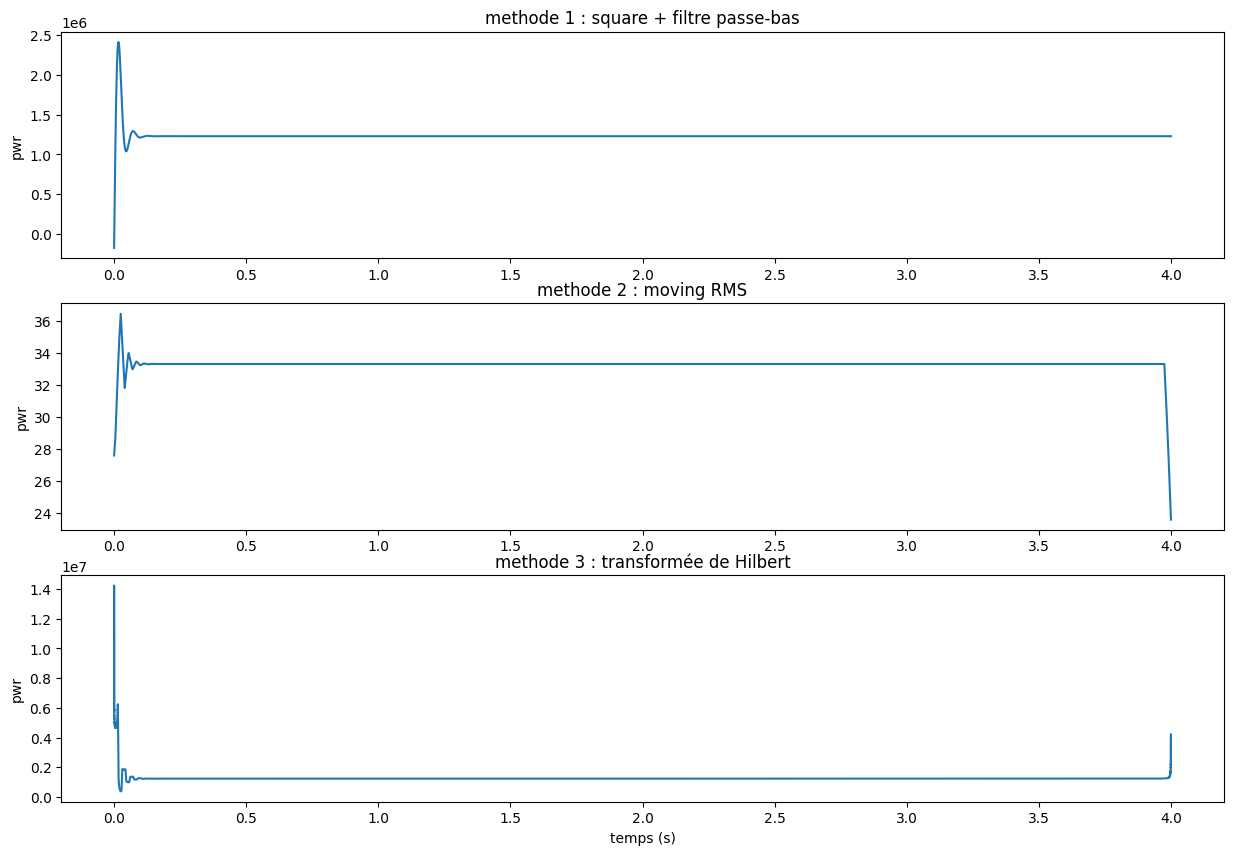

In [10]:
# Calcul de l'enveloppe de puissance
import time

# methode 1 : square + filtre passe-bas 
from scipy.signal import butter, filtfilt
start = time.time()
power = P**2
cutoff = 20  # enveloppe = ce qui varie lentement
b, a = butter(4, cutoff / (1 / (2*delta_t)), btype='low')
power_meth1 = filtfilt(b, a, power)
end = time.time()
temps1 = end - start

# methode 2 : moving RMS
window_ms = 50  # RMS window length
window_samples = int(fs * window_ms / 1000)
kernel = np.ones(window_samples) / window_samples
start = time.time()
power_meth2 = np.sqrt(np.convolve(P, kernel, mode='same'))
end = time.time()
temps2 = end - start

# methode 3 : transformée de Hilbert
from scipy.signal import hilbert
start = time.time()
analytic_signal = hilbert(P)
amplitude_envelope = np.abs(analytic_signal)
power_meth3 = amplitude_envelope**2
end = time.time()
temps3 = end - start

# plot
print(temps1, temps2, temps3)

plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(np.arange(len(power_meth1))*delta_t, power_meth1)
plt.title("methode 1 : square + filtre passe-bas")
plt.ylabel("pwr")
plt.subplot(312)
plt.plot(np.arange(len(power_meth2))*delta_t, power_meth2)
plt.title("methode 2 : moving RMS")
plt.ylabel("pwr")
plt.subplot(313)
plt.plot(np.arange(len(power_meth3))*delta_t, power_meth3)
plt.title("methode 3 : transformée de Hilbert")
plt.xlabel("temps (s)")
plt.ylabel("pwr")

In [7]:
from scipy.signal import butter, filtfilt

fs = 1/delta_t
cutoff = 20  # enveloppe = ce qui varie lentement
b, a = butter(4, cutoff / (fs / 2), btype='low')

def descripteur_regime(P, cutoff = 20, fs = 1/delta_t):
    power = P**2
    pwr = filtfilt(b, a, power)
    D_regime = np.var(pwr)/np.mean(pwr)
    return D_regime

# Détermination de $\epsilon_2$
dur = 0.5
D_regime = np.zeros(len(indexes))

for i, index in enumerate(indexes): 
    print("epoch :", i + 1, "/500")
    clarinette.params_controle_musicien(gamma[index[0]],zeta[index[1]])
    _, _, P, _, _ = clarinette.execution(dur, delta_t)
    D_regime[i] = descripteur_regime(P)

epoch : 1 /500
epoch : 2 /500
epoch : 3 /500
epoch : 4 /500
epoch : 5 /500
epoch : 6 /500
epoch : 7 /500
epoch : 8 /500
epoch : 9 /500
epoch : 10 /500
epoch : 11 /500
epoch : 12 /500
epoch : 13 /500
epoch : 14 /500
epoch : 15 /500
epoch : 16 /500
epoch : 17 /500
epoch : 18 /500
epoch : 19 /500
epoch : 20 /500
epoch : 21 /500
epoch : 22 /500
epoch : 23 /500
epoch : 24 /500
epoch : 25 /500
epoch : 26 /500
epoch : 27 /500
epoch : 28 /500
epoch : 29 /500
epoch : 30 /500
epoch : 31 /500
epoch : 32 /500
epoch : 33 /500
epoch : 34 /500
epoch : 35 /500
epoch : 36 /500
epoch : 37 /500
epoch : 38 /500
epoch : 39 /500
epoch : 40 /500
epoch : 41 /500
epoch : 42 /500
epoch : 43 /500
epoch : 44 /500
epoch : 45 /500
epoch : 46 /500
epoch : 47 /500
epoch : 48 /500
epoch : 49 /500
epoch : 50 /500
epoch : 51 /500
epoch : 52 /500
epoch : 53 /500
epoch : 54 /500
epoch : 55 /500
epoch : 56 /500
epoch : 57 /500
epoch : 58 /500
epoch : 59 /500
epoch : 60 /500
epoch : 61 /500
epoch : 62 /500
epoch : 63 /500
e

c:\Users\Lalie\Desktop\M2 2025-2026\PAM\codes\clarinette_classe.py:105: RuntimeWarning: invalid value encountered in scalar divide
  u = zeta * (1+p-gamma) * np.sqrt(np.abs(gamma-p)) * (gamma-p)/np.abs(gamma-p) # débit adimensionné


epoch : 458 /500
epoch : 459 /500
epoch : 460 /500
epoch : 461 /500
epoch : 462 /500
epoch : 463 /500
epoch : 464 /500
epoch : 465 /500
epoch : 466 /500
epoch : 467 /500
epoch : 468 /500
epoch : 469 /500
epoch : 470 /500
epoch : 471 /500
epoch : 472 /500
epoch : 473 /500
epoch : 474 /500
epoch : 475 /500
epoch : 476 /500
epoch : 477 /500
epoch : 478 /500
epoch : 479 /500
epoch : 480 /500
epoch : 481 /500
epoch : 482 /500
epoch : 483 /500
epoch : 484 /500
epoch : 485 /500
epoch : 486 /500
epoch : 487 /500
epoch : 488 /500
epoch : 489 /500
epoch : 490 /500
epoch : 491 /500
epoch : 492 /500
epoch : 493 /500
epoch : 494 /500
epoch : 495 /500
epoch : 496 /500
epoch : 497 /500
epoch : 498 /500
epoch : 499 /500
epoch : 500 /500


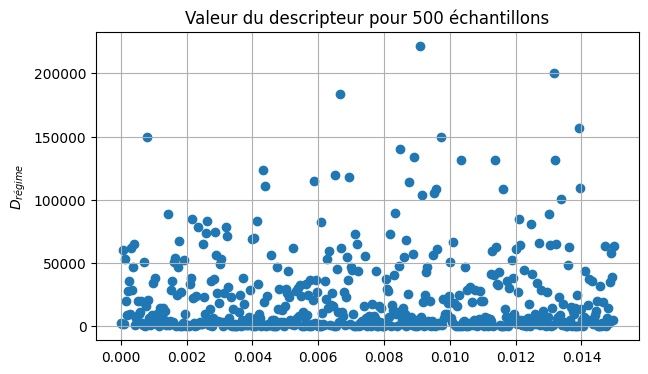

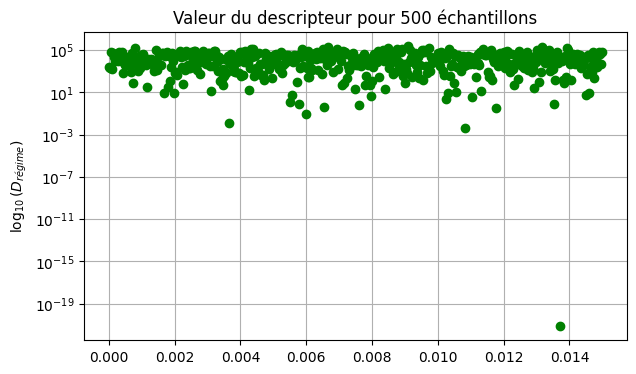

In [23]:
# esp2 = ...

plt.figure(figsize = (7,4))
plt.scatter(np.arange(len(D_regime))*delta_t, D_regime)
#plt.hlines(eps1, xmin, xmax, colors = "orange", linestyles = "--", label ="seuil de classification" )
plt.ylabel(r"$D_{régime}$")
plt.title("Valeur du descripteur pour 500 échantillons")
plt.grid()
plt.show()

plt.figure(figsize = (7,4))
plt.semilogy(np.arange(len(D_regime))*delta_t, D_regime, "go")
#plt.hlines(eps1, xmin, xmax, colors = "orange", linestyles = "--", label ="seuil de classification" )
plt.ylabel(r"$\log_{10}(D_{régime})$")
plt.title("Valeur du descripteur pour 500 échantillons")
plt.grid()

C:\Users\Lalie\AppData\Local\Temp\ipykernel_17096\1097299241.py:4: RuntimeWarning: divide by zero encountered in log10
  zi = np.full_like(xi, np.log10(eps2))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


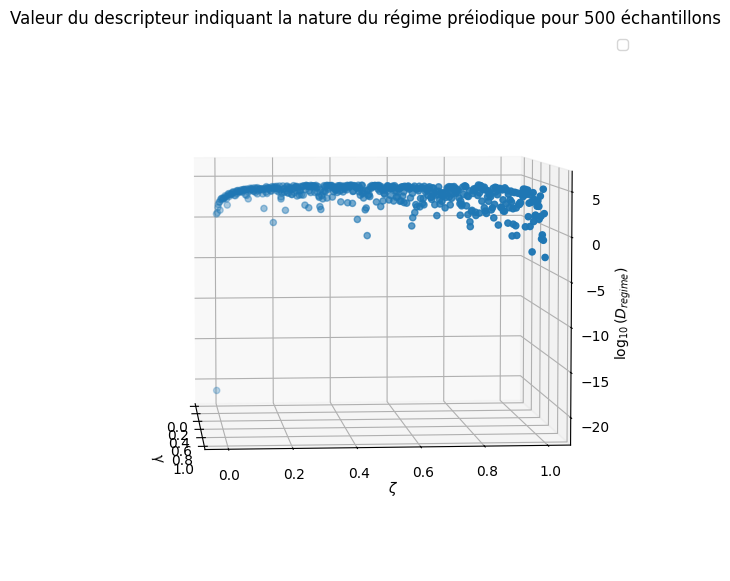

In [22]:
eps2 = 0
axis = np.linspace(0,1,500)
yi, xi = np.meshgrid(axis,axis)
zi = np.full_like(xi, np.log10(eps2))

fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gamma[indexes[:,0]], zeta[indexes[:,0]], np.log10(D_regime))
#ax.plot_surface(xi,yi,zi,alpha = 0.4, label = "seuil eps2")
ax.set_zlabel(r"$\log_{10}(D_{regime})$")
ax.set_ylabel(r"$\zeta$")
ax.set_xlabel(r"$\gamma$")
ax.set_title("Valeur du descripteur indiquant la nature du régime préiodique pour 500 échantillons")
ax.legend()
ax.view_init(elev=5., azim=-5, roll=0)

In [ ]:
class Classifier_regime():

    def __init__(self, eps2 = 1e-2, cutoff_lowpass = 20, delta_t = delta_t):
        from scipy.signal import butter, filtfilt
        self.eps2 = eps2
        self.fs = 1/delta_t
        self.cutoff = cutoff_lowpass 
        self.b, self.a = butter(4, self.cutoff / (self.fs / 2), btype='low')

    def pwr(self, P) : 
        """
        Renvoie l'enveloppe de puissance de la pression dans l'embouchure
        """
        power = filtfilt(self.b, self.a, P**2)
        return power

    def descripteur_regime(self, P):
        pwr = self.pwr(P)
        D_regime = np.var(pwr)/np.mean(pwr)
        return D_regime
    
    def classifieur_regime(self, P) :
        """
        Renvoie 0 pour un régime quai-périodique, 1 pour un régime périodique.  
        """
        c = 0
        D_note  = self.descripteur_regime(P)
        if D_note < self.eps2 :
            c = 1
        return c 

## 3. Justesse de la note

**Estimation de la fréquence fondamentale par la méthode du produit spectral** (source : TP TSM, Geoffroy Peeters)

Si nous notons $f_k = \frac{k}{N_{fft}}$ les fréquences discrètes de la DFT, le produit spectral est donné par:
\begin{equation}
    P(f_k) = \prod_{h=1}^{H} |X(h \cdot f_k)|
\end{equation}
Par défaut nous utiliserons $H$ = 4.

Détail des étapes de calcul :

Dans un premier temps, nous calculons la transformée de Fourier discrète (TFD) du signal $x(n)$ sur $N_{fft}$ points.
Nous commençons par multiplier $x(n)$ par une fenêtre de hamming de taille $L_n$ (ceci afin de diminuer la hauteur des lobes secondaires).

La longueur $L_n$ ainsi que le type de cette fenêtre détermine la **résolution fréquentielle**, i.e. le pouvoir de séparer en fréquence deux sinusoides adjacentes.

Le nombre de points de la la DFT, $N_{fft}$, détermine lui la **précision fréquentielle**., i.e. la distance en Hz entre $f_k$ et $f_{k+1}$.
Il faut impérativement utiliser une valeur de $N_{fft}$ supérieure à $L_n$. En pratique $N_{fft}$ est choisi comme une puissance de 2 de manière à pouvoir utiliser l'algorithme de FFT (Fast Fourier Transform). Ceci peut se calculer à l'aide de la fonction ```nextpow2```.

Calculer ensuite la transformée de Fourier Discrète $X(k)$.

50.79435314322834
55.670611044978266


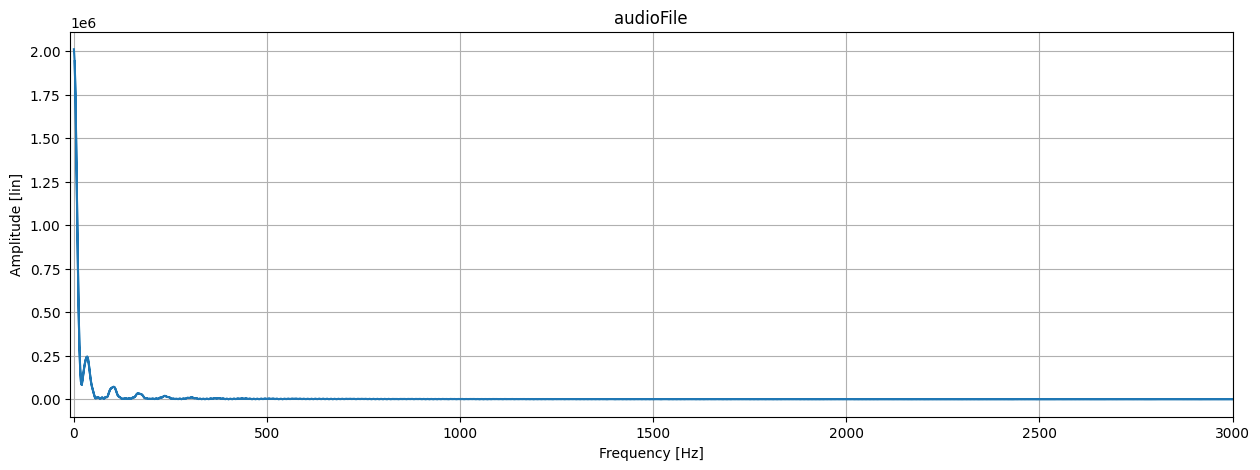

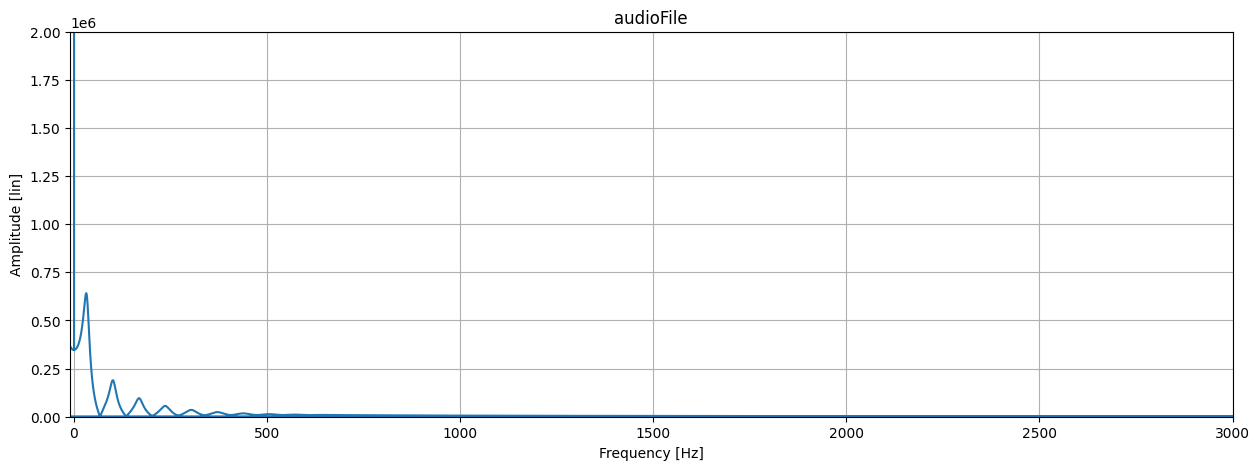

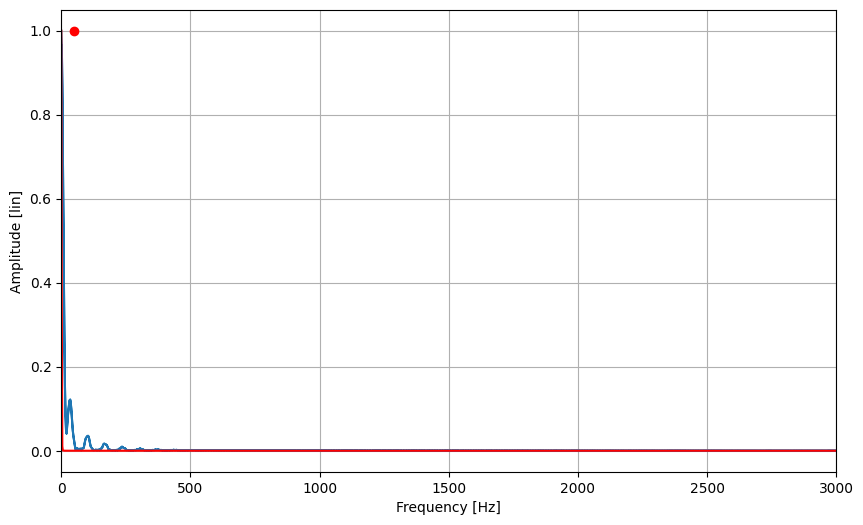

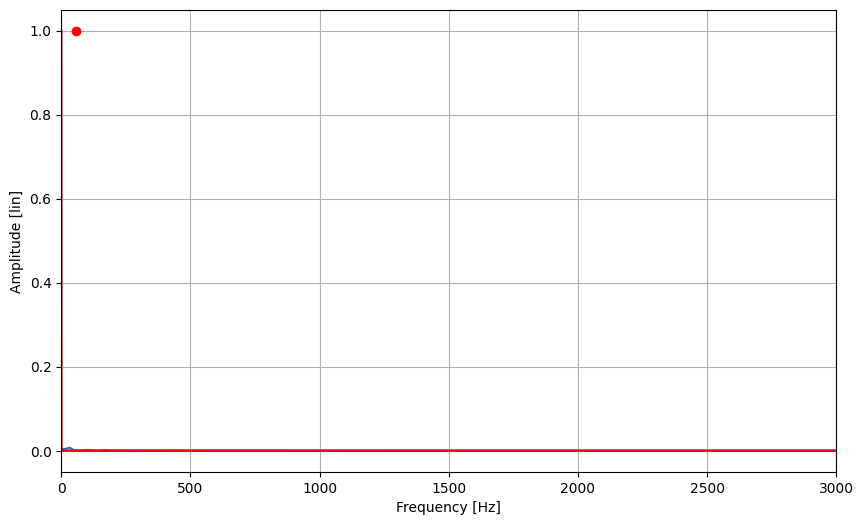

In [40]:
# Test du code sur des signaux de pression

fs = 1/delta_t

def F_plot1(x_v, y_v, labelX, labelY):
    plt.plot(x_v, y_v)
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.grid(True)
    return

def F_plot2(data_m, col_v=np.zeros(0), row_v=np.zeros(0), labelCol='', labelRow=''):
    plt.imshow(data_m, origin='lower', aspect='auto', extent=[row_v[0], row_v[-1], col_v[0], col_v[-1]], interpolation='nearest')
    plt.colorbar()
    plt.set_cmap('gray_r')
    plt.xlabel(labelRow)
    plt.ylabel(labelCol)
    plt.grid(True)
    return

do_student = True

def F_getSpectreFromAudio(x, L_n, Nfft, sr_hz, audioname):
    """
    inputs:
        - x: signal
        - L_n: window duration in samples
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - fftFreq_hz_v (N/2+1,): vector containing the DFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the DFT amplitudes
    """

    if do_student:
        sig = x[:L_n]*np.hamming(L_n)
        fftFreq_hz_v = np.abs(np.fft.fftfreq(Nfft, d=1/sr_hz))
        fftAmpl_v = np.abs(np.fft.fft(sig, Nfft))

    # +++++++++++++++++++++++++++++++
    plt.figure(figsize=(15, 5))
    F_plot1(fftFreq_hz_v, fftAmpl_v, 'Frequency [Hz]', 'Amplitude [lin]')
    plt.xlim((-10,3000))
    plt.title(audioname)
    # +++++++++++++++++++++++++++++++

    return fftFreq_hz_v, fftAmpl_v

#params fft
def nextpow2(i):
    n = 1
    while n < i:
        n *= 2
    return n
L_sec = 0.1
L_n = int(L_sec*fs)
Nfft = 4*nextpow2(L_n)

fftFreq_hz_v, fftAmpl_v = F_getSpectreFromAudio(P, L_n, Nfft, fs, "audioFile")

spec_P = np.fft.fft(P, n = 5*Nfft)
freq = np.fft.fftfreq(5*Nfft)
plt.figure(figsize=(15, 5))
F_plot1(freq*fs, np.abs(spec_P), 'Frequency [Hz]', 'Amplitude [lin]')
plt.xlim((-10,3000))
plt.ylim((-10, 2e6))
plt.title("audioFile")

def F_getF0FromSpectre(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz, display = True):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude
        - H: number of times the spectrum is decimated
        - fmin_hz: minimum frequency in Hz to look for F0
        - fmax_hz: maximum frequency in Hz to look for F0
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - spFreq_hz_v: vector containing the SpectralProduct frequencies in Hz
        - spAmpl_v: vector containing the SpectralProduct amplitudes
        - f0_hz: estimated F0 in Hz
    """

    if do_student:
        R = int(Nfft/(2*H) + 1)
        spAmpl_v = np.ones(R)
        spFreq_hz_v = fftFreq_hz_v[:R]
        for h in range(H) :
          X = fftAmpl_v[::h+1] 
          spAmpl_v = spAmpl_v*X[:R]
        Nmin = int(fmin_hz*Nfft/sr_hz)
        Nmax = min(R,int(fmax_hz*Nfft/sr_hz))
        i_max = np.argmax(spAmpl_v[Nmin:Nmax]) + Nmin
        f0_hz = spFreq_hz_v[i_max]
        
    # +++++++++++++++++++++++++++++++
    if display : 
        plt.figure(figsize=(10,6))
        F_plot1(fftFreq_hz_v, fftAmpl_v/np.max(fftAmpl_v), 'Frequency [Hz]', 'Amplitude [lin]')
        plt.plot(spFreq_hz_v, spAmpl_v/np.max(spAmpl_v), 'r')
        plt.xlim((0,3000))
        plt.plot(f0_hz, 1, 'ro')
    # +++++++++++++++++++++++++++++++

    return spFreq_hz_v, spAmpl_v, f0_hz

spFreq_hz_v, spAmpl_v, f0_hz = F_getF0FromSpectre(fftFreq_hz_v, fftAmpl_v, 4, 50, 900, Nfft, fs)
print(f0_hz)
spFreq_hz_v, spAmpl_v, f0_hz = F_getF0FromSpectre(freq*fs, np.abs(spec_P), 4, 50, 900, 5*Nfft, fs)
print(f0_hz)


In [ ]:
class Classifier_justesse():

    def __init__(self, f_ref, eps3 = 5, delta_t = delta_t, L_sec = 0.1, H = 4, fmin = 50, fmax = 900):
        self.f_ref = f_ref
        self.eps3 = eps3 # l'écart maximal en cents à la note de référence. Par défaut : 5 cents
        # params fft
        self.fs = 1/delta_t
        self.L_sec = L_sec
        self.L_n = int(L_sec*self.fs)
        self.Nfft = 4*self.nextpow2(self.L_n)
        # params produit spectral
        self.H = H
        self.fmin = fmin
        self.fmax = fmax


    def nextpow2(self, i):
        n = 1
        while n < i:
            n *= 2
        return n
    
    def get_spectre(self, x):
        sig = x[:L_n]*np.hamming(self.L_n)
        fftFreq_hz_v = np.abs(np.fft.fftfreq(self.Nfft, d=1/self.fs))
        fftAmpl_v = np.abs(np.fft.fft(sig, self.Nfft))
        return fftFreq_hz_v, fftAmpl_v

    def get_pitch(self, P):
        fftFreq_hz_v, fftAmpl_v = self.get_spectre(P)
        R = int(self.Nfft/(2*self.H) + 1)
        spAmpl_v = np.ones(R)
        spFreq_hz_v = fftFreq_hz_v[:R]
        for h in range(self.H) :
          X = fftAmpl_v[::h+1] 
          spAmpl_v = spAmpl_v*X[:R]
        Nmin = int(self.fmin*Nfft/self.fs)
        Nmax = min(R,int(self.fmax*Nfft/self.fs))
        i_max = np.argmax(spAmpl_v[Nmin:Nmax]) + Nmin
        f0_hz = spFreq_hz_v[i_max]
        return f0_hz

    def descripteur_justesse(self, P):
        f_act = self.get_pitch(P)
        D_note = 1200*np.log2(f_act/self.f_ref)
        return D_note
    
    def classifieur_justesse(self,P):
        """
        Renvoie 0 si la note n'est pas juste, 1 sinon.  
        """
        c = 0
        D_note  = self.descripteur_justesse(P)
        if np.abs(D_note) < self.eps3 :
            c = 1
        return c

## 4. Longueur du transitoire d'attaque

Méthode temporelle (V. Salvador Castrillo) :
- fréquence d'oscillation qui correspond à la fréquence que l'on souhaite exciter à $\pm$ 0.5 1/2 ton (100 cents) : $f_{osc} \in [f_{ref} - 2^{1/12}*f_{ref}, f_{ref} + 2^{1/12}*f_{ref}]$
- périodicité stable ce qui correspond à une certaine limite de l'écart type : $\sigma_w \leq 0.6$

Fonctionne avec les violons : le régime de Helmholtz correspond à un glissement par période. https://github.com/VictorSalvador/transient_detector.git

Pour déterminer $f_{osc}$, dans sa thèse : 
$$
\begin{equation}
f_{osc}(n) = \frac{N_{pics}}{L_w}
\end{equation}
$$

$N_{pics}$ est le nombre de pics du signal $|x'| = |x(n+1) - x(n)|$ dans une fenêtre rectangulaire de longueur $L_w$.

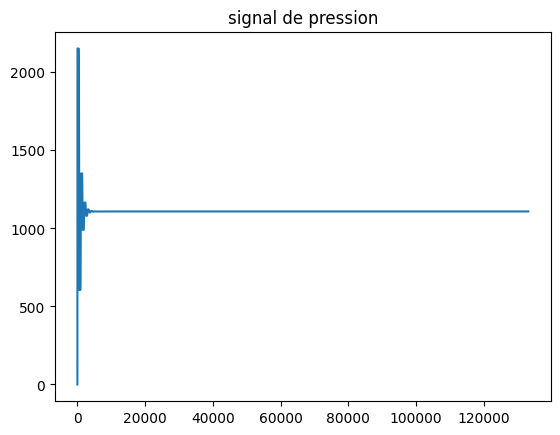

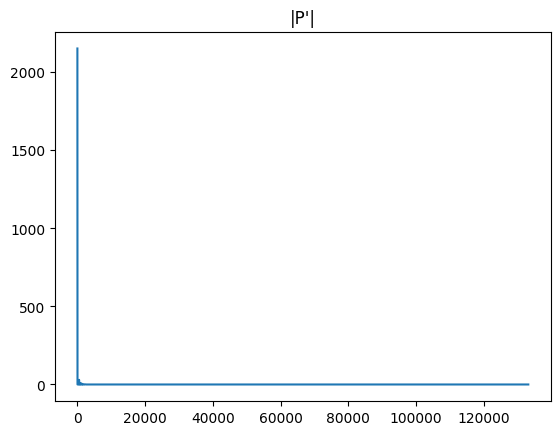

In [46]:
# calcul de |x'|
abs_sig_diff = np.abs(np.diff(P))
# # Minimum height of the peaks: Adaptative threshold varying with
# # abs_sig_diff envelope
# # --> Minimum height = pp_height = maximum peak of the windowed
# #                      abs_sig_diff signal times pp_height_factor

# pp_height = np.zeros_like(abs_sig_diff)

# for i in range(len(abs_sig_diff)-win_len):
#     pp_height[int(win_len/2)+i] = np.max(abs_sig_diff[i:win_len+i]) \
#         * pp_height_factor

# # Adjust initial and final height of signal (if not, height=0)
# pp_height[0:int(win_len/2)] = pp_height[int(win_len/2)]
# pp_height[-int(win_len/2):] = pp_height[-int(win_len/2)-1]

# # Detect peaks
# peaks, _ = scipy.signal.find_peaks(abs_sig_diff, height=pp_height,
#                                     prominence=pp_prominences[string],
#                                     distance=pp_distances[string])

plt.plot(np.arange(len(P)), P)
plt.title("signal de pression")
plt.show()

plt.plot(np.arange(len(abs_sig_diff)), abs_sig_diff)
plt.title("|P'|")
# plt.xlim((0,100))
# plt.ylim((0, 100))
plt.show()

## 5. Bifurcation directe ou inverse